In [ ]:
import torch
from torch.utils import data
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
from skimage import io, transform

## Turning on cuda gpu

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available

## Getting data

In [ ]:
# !unzip "/content/drive/My Drive/Colab Notebooks/data_semantics.zip"
# !unzip "/content/drive/My Drive/Colab Notebooks/devkit_semantics.zip"

#### Defining dataloader params and normalizing values

In [ ]:
params = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 4}

data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

#### Defining custom tranform for target

In [ ]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Custom KittiDataset



In [ ]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
import os
import collections
import pdb

class KittiDataset(Dataset): # Pytorch dataset class
# important functions len and getitem
# Load data in an efficient way, like multiple CPUs
# To speed up process in training specially for HD images so it can have multithreading features
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

        self.images = os.listdir(os.path.join(root_dir, 'image_2'))
        self.labels = os.listdir(os.path.join(root_dir, 'semantic'))
        self.gt = os.listdir(os.path.join(root_dir, 'semantic_rgb'))

    def __len__(self):
      return len(self.images)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
            idx = idx.tolist()

      img_path = os.path.join(self.root_dir + '/image_2', self.images[idx])
      label_path = os.path.join(self.root_dir + '/semantic', self.images[idx])
      gt_path = os.path.join(self.root_dir + '/semantic_rgb', self.images[idx])

      image = Image.open(img_path)
      label = Image.open(label_path)
      gt = Image.open(gt_path)

      sample = {'image': image, 'label': label, 'gt': gt}

      if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['label'] = self.target_transform(sample['label'])
            sample['gt'] = self.target_transform(sample['gt'])
            
      return sample

#### Loading data using dataloaders

In [ ]:
class ConvertToBackground(object):
  def __call__(self, img):
    img = np.asarray(img, dtype=np.long)
    img[img == 255] = 0
    img = torch.from_numpy(img)
    return img

In [ ]:
from torch.utils.data import random_split
root_dir = '/content/drive/My Drive/Colab Notebooks/data_semantics/training'

data_set = KittiDataset(root_dir=root_dir)

In [ ]:
input_size = (224, 224)

img_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

target_transform = transforms.Compose([
    transforms.Resize(input_size),
    ConvertToBackground()
])

transformed_dataset = KittiDataset(root_dir=root_dir, 
                                   transform=img_transform, target_transform=target_transform)

val_size = 30
test_size = 30
train_size = len(transformed_dataset) - val_size - test_size

train_set, val_train_set = random_split(transformed_dataset, [train_size, (val_size + test_size)])
val_set, test_set = random_split(val_train_set, [val_size, test_size])

train_loader = data.DataLoader(train_set, **params)
val_loader = data.DataLoader(val_set, **params)
test_loader = data.DataLoader(test_set, **params)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(str(i) + " " + str(sample['image'].shape) + " " + str(sample['label'].shape))

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([224, 224])
1 torch.Size([3, 224, 224]) torch.Size([224, 224])
2 torch.Size([3, 224, 224]) torch.Size([224, 224])
3 torch.Size([3, 224, 224]) torch.Size([224, 224])


## Downloading pretrained vgg16 model

In [ ]:
vgg16 = models.vgg16(pretrained=True)

#### Freezing convolution layers

In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad = False

## Defining FCN32 network

In [ ]:
num_classes = 35

class FCN32(nn.Module):
  def __init__(self):
    super(FCN32, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, num_classes, 1),
      nn.ConvTranspose2d(num_classes, num_classes, 224, stride=32)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

fcn = FCN32()
fcn.to(device)

FCN32(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

#### Checks to see proper weight updation and correct transfer

## Defining FCN16 network

In [ ]:
num_classes = 35

class FCN16(nn.Module):
  def __init__(self):
    super(FCN16, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, num_classes, 1)
    )
    self.score_pool4 = nn.Conv2d(512, num_classes, 1)
    self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 14, stride=2, bias=False)
    self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, 16, stride=16, bias=False)

  def forward(self, x):
    pool4 = self.features[:-7](x)
    pool5 = self.features[-7:](pool4)
    pool5_upscored = self.upscore2(self.classifier(pool5))
    pool4_scored = self.score_pool4(pool4)
    combined = pool4_scored + pool5_upscored
    res = self.upscore16(combined)
    return res

fcn = FCN16()
fcn.to(device)

FCN16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

## Defining criterion and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
betas = (0.5, 0.999)

optimizer = optim.Adam(fcn.parameters(), lr=0.001, betas=betas)

## Defining function that calculates mean iou for training and val set

In [ ]:
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou

## Training and validation loop

In [ ]:
best_loss = 1000000000
num_epochs = 140

train_loss_history = []
val_loss_history = []
train_iou_history = []
val_iou_history = []

for epoch in range(num_epochs):
  val_running_iou = 0
  val_running_loss = 0
  train_running_iou = 0
  train_running_loss = 0
  j = 0
  fcn.train()
  for i, dat in enumerate(train_loader):

    j += 1
    # Get image, label pair
    inputs, labels = dat['image'], dat['label']

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Set parameter gradients to 0
    optimizer.zero_grad()

    # Forward pass for a batch
    outputs = fcn(inputs)
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    gt = labels.detach().cpu().numpy()

    # Compute loss
    loss = criterion(outputs, labels)
    train_running_loss += loss

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(35)))
    mean_iou = get_mean_iou(conf_mat=conf_mat)
    train_running_iou = mean_iou

    # Backpropagate
    loss.backward()

    # Update the weights
    optimizer.step()

  # Averaging loss and scores
  avg_train_loss = float(train_running_loss)/(j)
  avg_train_iou = float(train_running_iou)/(j)

  train_loss_history.append(avg_train_loss)
  train_iou_history.append(avg_train_iou)

  fcn.eval()
  with torch.no_grad():
    for k, dat1 in enumerate(val_loader):
      # Get image, label pair
      inputs1, labels1 = dat1['image'], dat1['label']

      # # Using GPU
      inputs1 = inputs1.to(device)
      labels1 = labels1.to(device)

      # Predicting segmentation for val inputs
      outputs1 = fcn(inputs1)

      # Compute CE loss and aggregate it
      loss1 = criterion(outputs1, labels1)
      val_running_loss += loss1

      # Reshaping prediction segmentations and actual segmentations for iou and dice score
      preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
      gt = labels1.detach().cpu().numpy()

      # Compute confusion matrix
      conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(35)))

      # Computing iou and dice scores and aggregating them
      mean_iou = get_mean_iou(conf_mat=conf_mat)
      val_running_iou += mean_iou

    avg_val_loss = float(val_running_loss)/(k+1)
    avg_val_iou = float(val_running_iou)/(k+1)

    val_loss_history.append(avg_val_loss)
    val_iou_history.append(avg_val_iou)

    if avg_val_loss < best_loss:
      best_loss = avg_val_loss
      torch.save(fcn.state_dict(), '/content/best_model_fcn.pth.tar')

    # Visualizations for batch wise metrics
    print('epoch {}, training loss: {}, iou score: {}'.format(epoch+1, avg_train_loss, avg_train_iou))
    print('epoch {}, validation loss: {}, iou score: {}'.format(epoch+1, avg_val_loss, avg_val_iou))

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


epoch 1, training loss: 1.5017423629760742, iou score: 0.002014228703145908
epoch 1, validation loss: 1.699780782063802, iou score: 0.06978623120535911
epoch 2, training loss: 1.4304516656058175, iou score: 0.0027911893499759236
epoch 2, validation loss: 1.7992968559265137, iou score: 0.06733212162425505
epoch 3, training loss: 1.3789806365966797, iou score: 0.008487598303214283
epoch 3, validation loss: 1.5455258687337239, iou score: 0.10739460716697209
epoch 4, training loss: 1.2782128197806222, iou score: 0.008729891689457552
epoch 4, validation loss: 1.5377294222513835, iou score: 0.1082456357897008
epoch 5, training loss: 1.1922695977347237, iou score: 0.0057765645842074165
epoch 5, validation loss: 1.6536587079366047, iou score: 0.08298761117621115
epoch 6, training loss: 1.2273947851998466, iou score: 0.0036554859040748987
epoch 6, validation loss: 1.6506013870239258, iou score: 0.10769429935366133
epoch 7, training loss: 1.1959806169782365, iou score: 0.006152902860428504
epoch

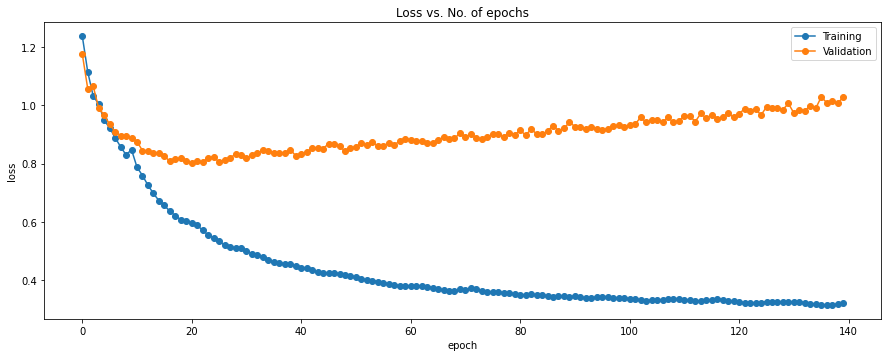

In [ ]:
def plot_losses(train, val):
    plt.subplot(2, 1, 1)
    plt.plot(train, '-o')
    plt.plot(val, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.gcf().set_size_inches(15, 12)

plot_losses(train_loss_history, val_loss_history)

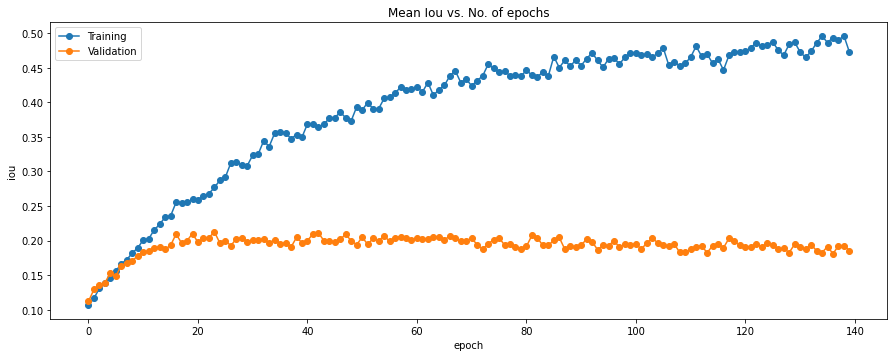

In [ ]:
def plot_iou(train, val):
    plt.subplot(2, 1, 1)
    plt.plot(train, '-o')
    plt.plot(val, '-o')
    plt.xlabel('epoch')
    plt.ylabel('iou')
    plt.legend(['Training', 'Validation'])
    plt.title('Mean Iou vs. No. of epochs');
    plt.gcf().set_size_inches(15, 12)

plot_iou(train_iou_history, val_iou_history)

## Examining performance on entire test set

#### Loading best saved model

In [ ]:
model = FCN32()
model.load_state_dict(torch.load('/content/best_model_fcn.pth.tar'))
model.to(device)
model.eval()

In [ ]:
model = FCN16()
model.load_state_dict(torch.load('/content/best_model_fcn.pth.tar'))
model.to(device)
model.eval()

FCN16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

## Calculating Pixel level IOU and Mean IOU on entire test set

In [ ]:
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou, iou

In [ ]:
overall_conf_mat = np.zeros((35, 35))
with torch.no_grad():
  for k, dat1 in enumerate(test_loader):
    # Get image, label pair
    inputs1, labels1 = dat1['image'], dat1['label']

    # Using GPU
    inputs1 = inputs1.to(device)
    labels1 = labels1.to(device)

    # Predicting segmentation for val inputs
    outputs1 = model(inputs1)

    preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
    gt = labels1.detach().cpu().numpy()

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(35)))
    overall_conf_mat += conf_mat

mean_iou, iou = get_mean_iou(conf_mat=overall_conf_mat)
print('IOU: {}'.format(iou))
print('Mean IOU: {}'.format(np.round(mean_iou, 2)))

IOU: [0.         0.         0.         0.         0.421875   0.05075758
 0.2601626  0.87887102 0.55460552 0.31881262 0.37165304 0.7448051
 0.19798761 0.09071496 0.4253857  0.00647715 0.00618673 0.11895879
 0.03682688 0.13758515 0.27939644 0.79163026 0.61728869 0.79067183
 0.00425894 0.00504881 0.76342157 0.05257423 0.69709763 0.20661157
 0.57954545 0.276      0.0083682  0.373297          nan]
Mean IOU: 0.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Visualizing results

In [ ]:
def decode_segmap(image, nc=35):

  label_colors = np.array([(0, 0, 0),
              (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (111, 74,  0),
              ( 81,  0, 81), (128, 64,128), (244, 35,232), (250,170,160), (230,150,140),
              ( 70, 70, 70), (102,102,156), (190,153,153), (180,165,180), (150,100,100),
              (150,120, 90), (153,153,153), (153,153,153), (250,170, 30), (220,220,0),
              (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60), (255,  0,  0),
              (  0,  0,142), (  0,  0, 70), (  0, 60,100), (  0,  0, 90), (  0,  0,110),
              (  0, 80,100), (  0,  0,230), (119, 11, 32), (  0,  0,142)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}

test_loader = data.DataLoader(test_set, **params)

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

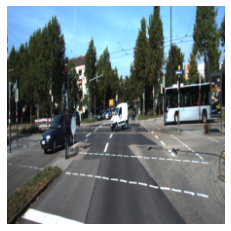

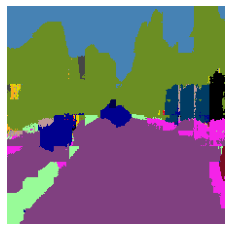

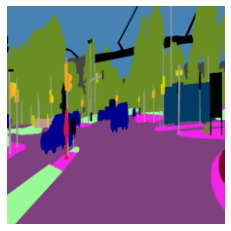

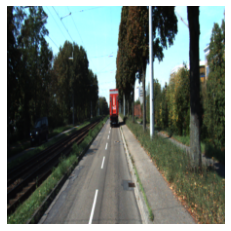

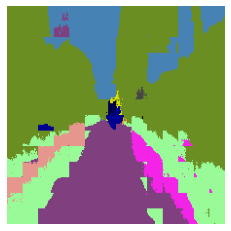

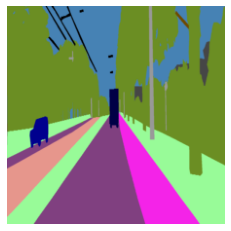

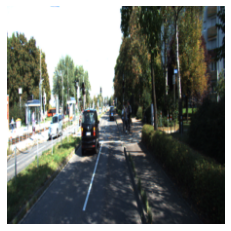

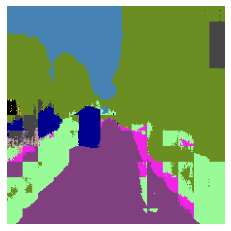

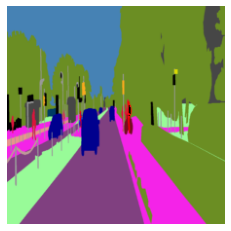

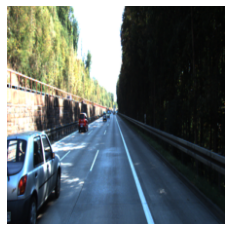

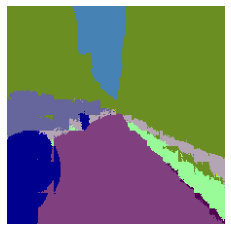

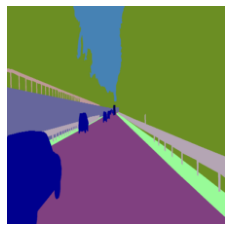

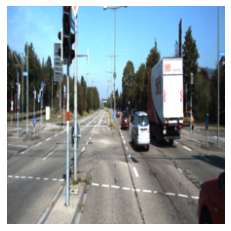

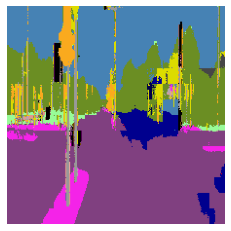

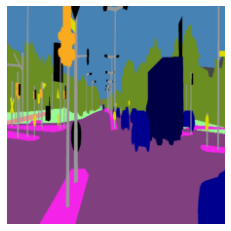

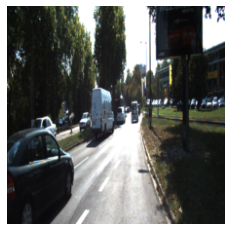

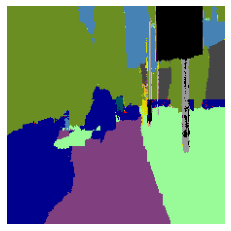

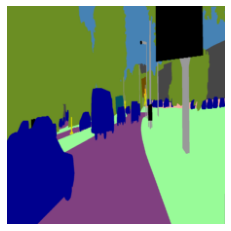

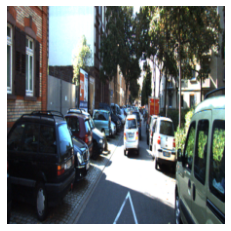

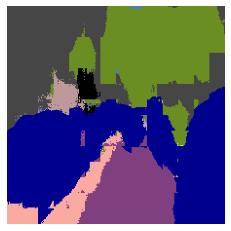

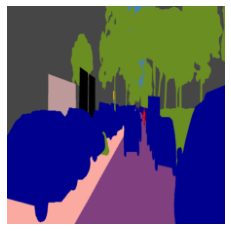

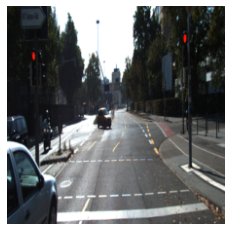

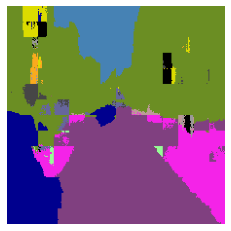

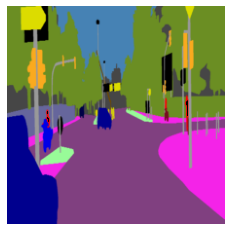

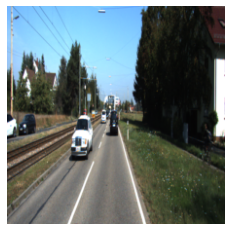

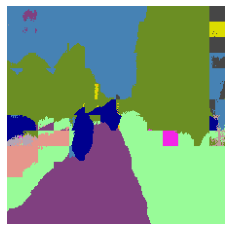

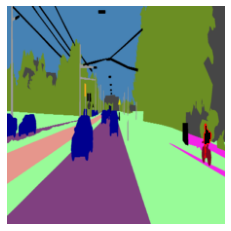

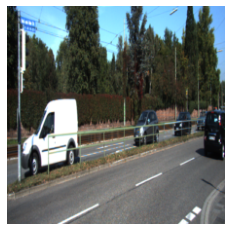

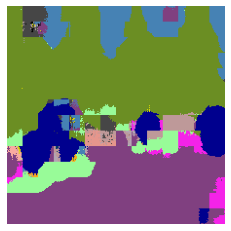

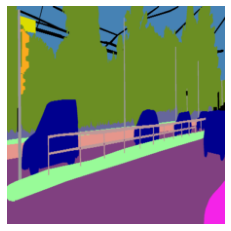

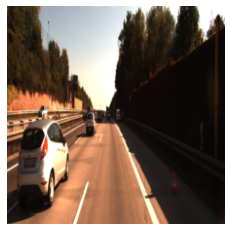

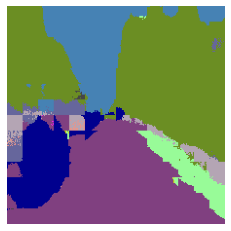

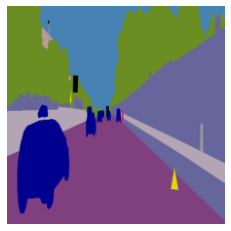

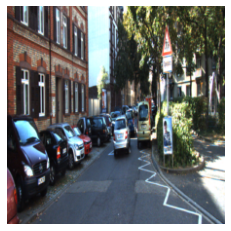

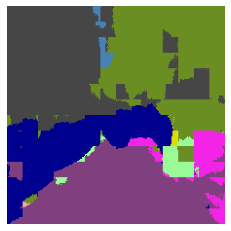

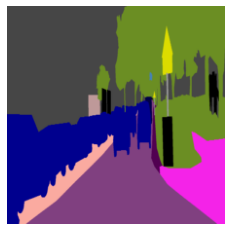

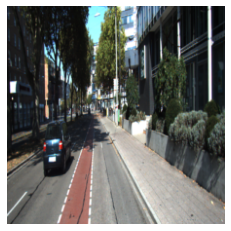

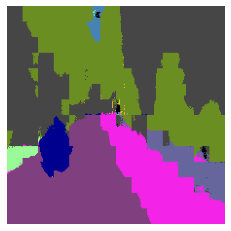

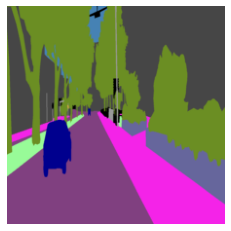

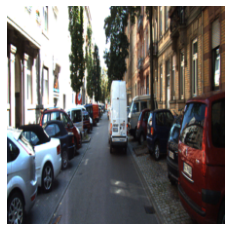

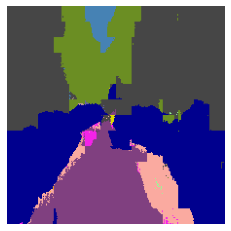

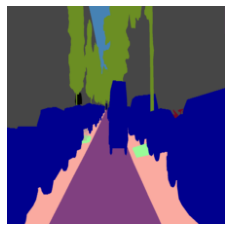

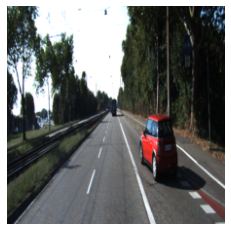

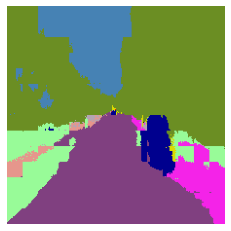

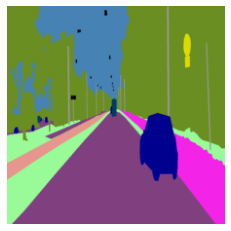

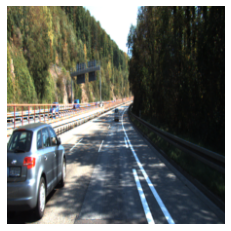

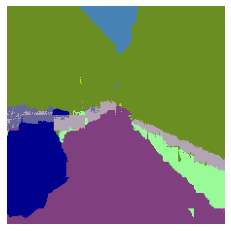

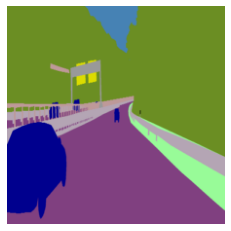

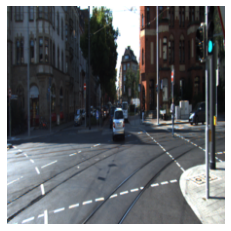

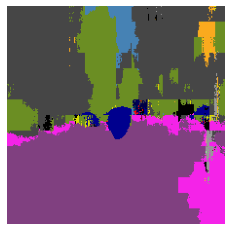

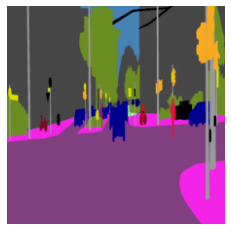

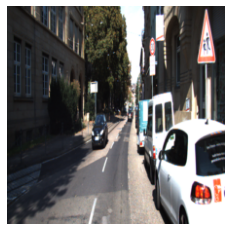

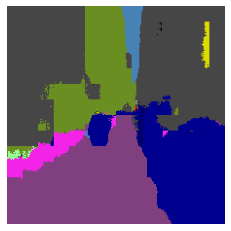

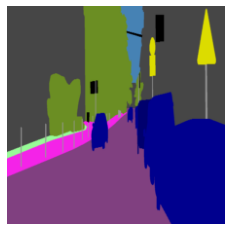

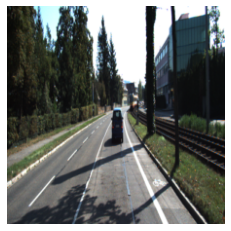

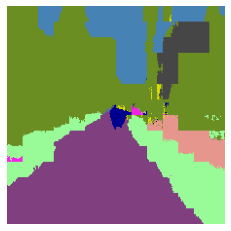

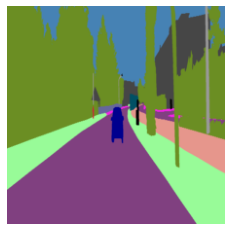

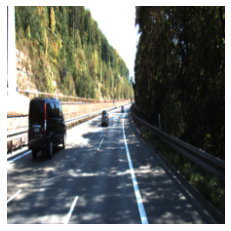

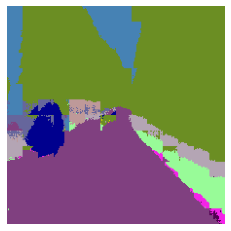

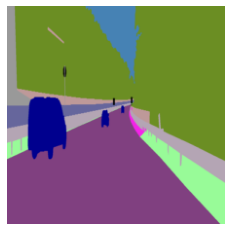

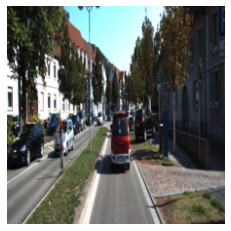

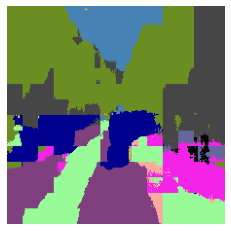

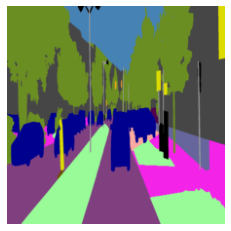

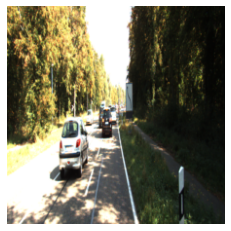

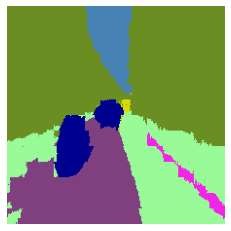

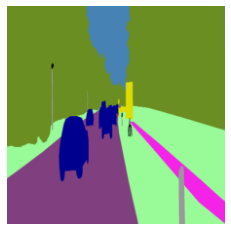

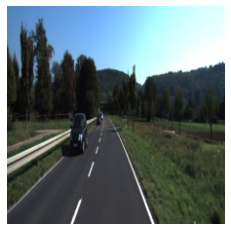

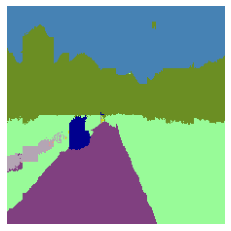

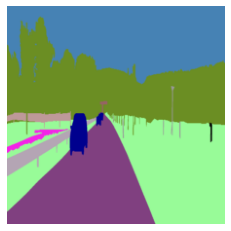

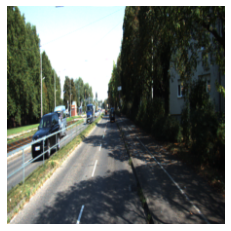

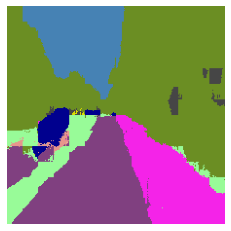

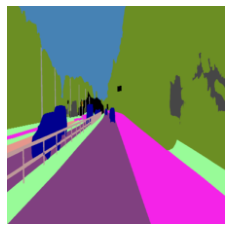

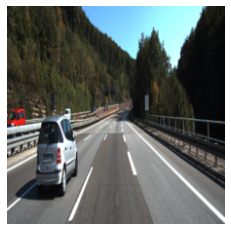

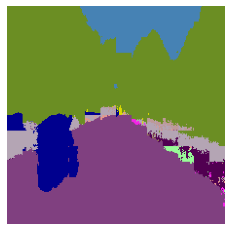

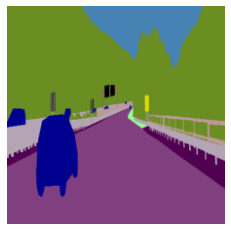

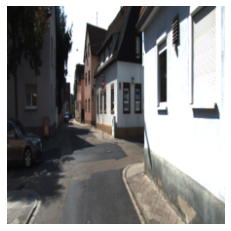

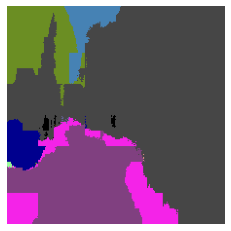

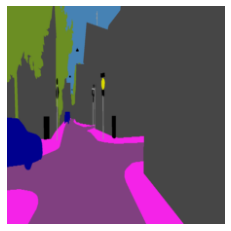

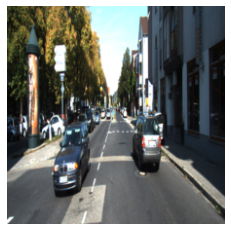

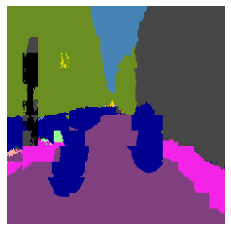

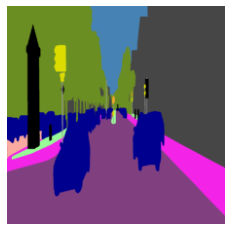

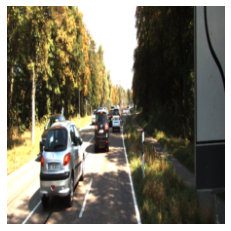

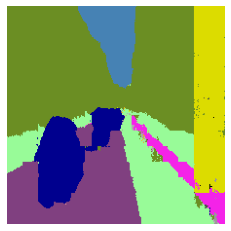

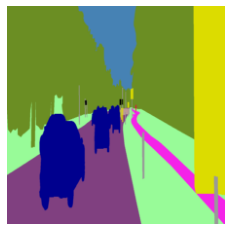

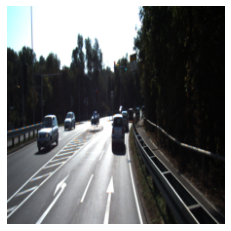

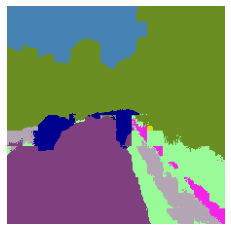

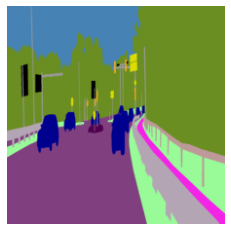

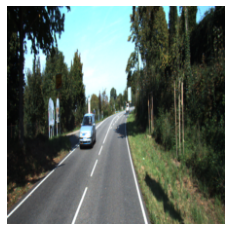

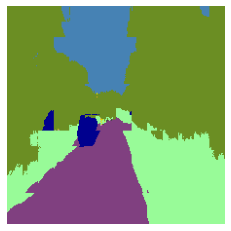

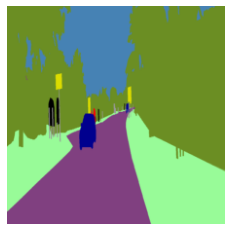

In [ ]:
with torch.no_grad():
  for k, dat in enumerate(test_loader):
    # Get image, label pair
    inputs, labels, gt = dat['image'], dat['label'], dat['gt']

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    pred = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    
    # Getting the segmentation
    segmentation = decode_segmap(pred)

    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    unnormalized_image = unorm(inputs[0].cpu())
    image_array = np.transpose(unnormalized_image.numpy(), (1, 2, 0))

    plt.imshow(image_array); plt.axis('off');
    plt.show()

    plt.imshow(segmentation);  plt.axis('off');
    plt.show()

    plt.imshow(gt[0]);  plt.axis('off');
    plt.show()

    if k == 10:
        break